In [116]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
import statsmodels.tsa.stattools as ts
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima
import seaborn as sns


In [ ]:
# Read in the data
census_df = pd.read_excel('data/census.xlsx')
census_df.head()
cenus_og_df = census_df.copy()

In [118]:
#### FEature Engineering

# Add weekday and month as features
census_df['Weekday'] = census_df['Date'].dt.weekday
census_df['Month'] = census_df['Date'].dt.month
census_df['Date'] = census_df['Date'].dt.strftime('%Y-%m-%d')
census_df['Date'] = pd.to_datetime(census_df['Date'], format='%Y-%m-%d')
census_df = census_df.set_index('Date')
census_df = census_df.sort_index()
census_df = census_df.drop(columns=['id'])
census_df.head()

,Department,Census,Weekday,Month
Date,,,,
2023-01-01,3100 INTENSIVE CARE,15,6,1
2023-01-01,EMERGENCY ROOM,49,6,1
2023-01-01,4100 MED SURG,5,6,1
2023-01-01,6100 TELEMETRY,11,6,1
2023-01-01,6200 TELEMETRY,12,6,1


In [119]:
census_df.tail()

,Department,Census,Weekday,Month
Date,,,,
2024-10-31,NICU A,5,3,10
2024-10-31,3100 INTENSIVE CARE,10,3,10
2024-10-31,NICU B,7,3,10
2024-10-31,7200 TELEMETRY,12,3,10
2024-10-31,POSTPARTUM EAST,9,3,10


In [ ]:
# Filter the dataframe to only include rows where the 'Department' column contains 'TELEMETRY'
tele_census_df = census_df[census_df['Department'].str.contains('TELEMETRY', case=False, na=False)]
tele_census_df.head()

,Department,Census,Weekday,Month
Date,,,,
2023-01-01,6100 TELEMETRY,11,6,1
2023-01-01,6200 TELEMETRY,12,6,1
2023-01-01,6300 TELEMETRY,9,6,1
2023-01-01,7100 TELEMETRY,13,6,1
2023-01-01,7300 TELEMETRY,9,6,1


In [ ]:
# Replace any Departments containing 'TELEMETRY' with 'TELEMETRY'
tele_census_df.loc[tele_census_df['Department'].str.contains('TELEMETRY', case=False, na=False), 'Department'] = 'TELEMETRY'
tele_census_df.head()

,Department,Census,Weekday,Month
Date,,,,
2023-01-01,TELEMETRY,11,6,1
2023-01-01,TELEMETRY,12,6,1
2023-01-01,TELEMETRY,9,6,1
2023-01-01,TELEMETRY,13,6,1
2023-01-01,TELEMETRY,9,6,1


In [122]:
df_influenza = pd.read_excel('data/lab_influenza.xlsx')
df_influenza.head()

,_id,season,date,perFlu
0,1,2020/2021,2020-07-04,0.0
1,2,2020/2021,2020-07-11,0.0
2,3,2020/2021,2020-07-18,0.0
3,4,2020/2021,2020-07-25,0.0
4,5,2020/2021,2020-08-01,0.0


In [123]:
# Convert 'date' column (if present) to datetime format
if 'date' in df_influenza.columns:
  df_influenza['date'] = pd.to_datetime(df_influenza['date'])

# Set the start and end dates for the census data
start_date = pd.to_datetime("2023-01-01")
end_date = pd.to_datetime("2024-10-31")

# Resample the influenza data to daily with forward fill (ffill)
df_daily_influenza = (df_influenza.set_index('date')  # Assuming a 'date' column exists
                     .resample('D')  # Resample to daily frequency
                     .ffill()  # Forward fill missing values
                     .reset_index())  # Convert back to DataFrame

# Filter data for the census timeframe
df_daily_influenza = df_daily_influenza[(df_daily_influenza['date'] >= start_date) & (df_daily_influenza['date'] <= end_date)]

# Note: This code assumes the influenza data has a 'date' column. 
# Modify the code based on the actual column name for dates in your data.

print(df_daily_influenza)

           date  _id     season     perFlu
911  2023-01-01  130  2022/2023  12.871542
912  2023-01-02  130  2022/2023  12.871542
913  2023-01-03  130  2022/2023  12.871542
914  2023-01-04  130  2022/2023  12.871542
915  2023-01-05  130  2022/2023  12.871542
...         ...  ...        ...        ...
1576 2024-10-27  225  2024/2025   1.682481
1577 2024-10-28  225  2024/2025   1.682481
1578 2024-10-29  225  2024/2025   1.682481
1579 2024-10-30  225  2024/2025   1.682481
1580 2024-10-31  225  2024/2025   1.682481

[670 rows x 4 columns]


In [124]:
# Merge the tele_census_df and df_daily_influenza DataFrames
merged_df = tele_census_df.merge(df_daily_influenza, left_index=True, right_on='date')

In [125]:
#agg_tele_census_df = merged_df.groupby('Date')[['Census']].sum()
agg_tele_census_df = merged_df.groupby('date').agg({'Census': 'sum', 'Weekday': 'first', 'Month': 'first', 'perFlu': 'first'})
agg_tele_census_df.head()

,Census,Weekday,Month,perFlu
date,,,,
2023-01-01,63,6,1,12.871542
2023-01-02,59,0,1,12.871542
2023-01-03,61,1,1,12.871542
2023-01-04,67,2,1,12.871542
2023-01-05,67,3,1,12.871542


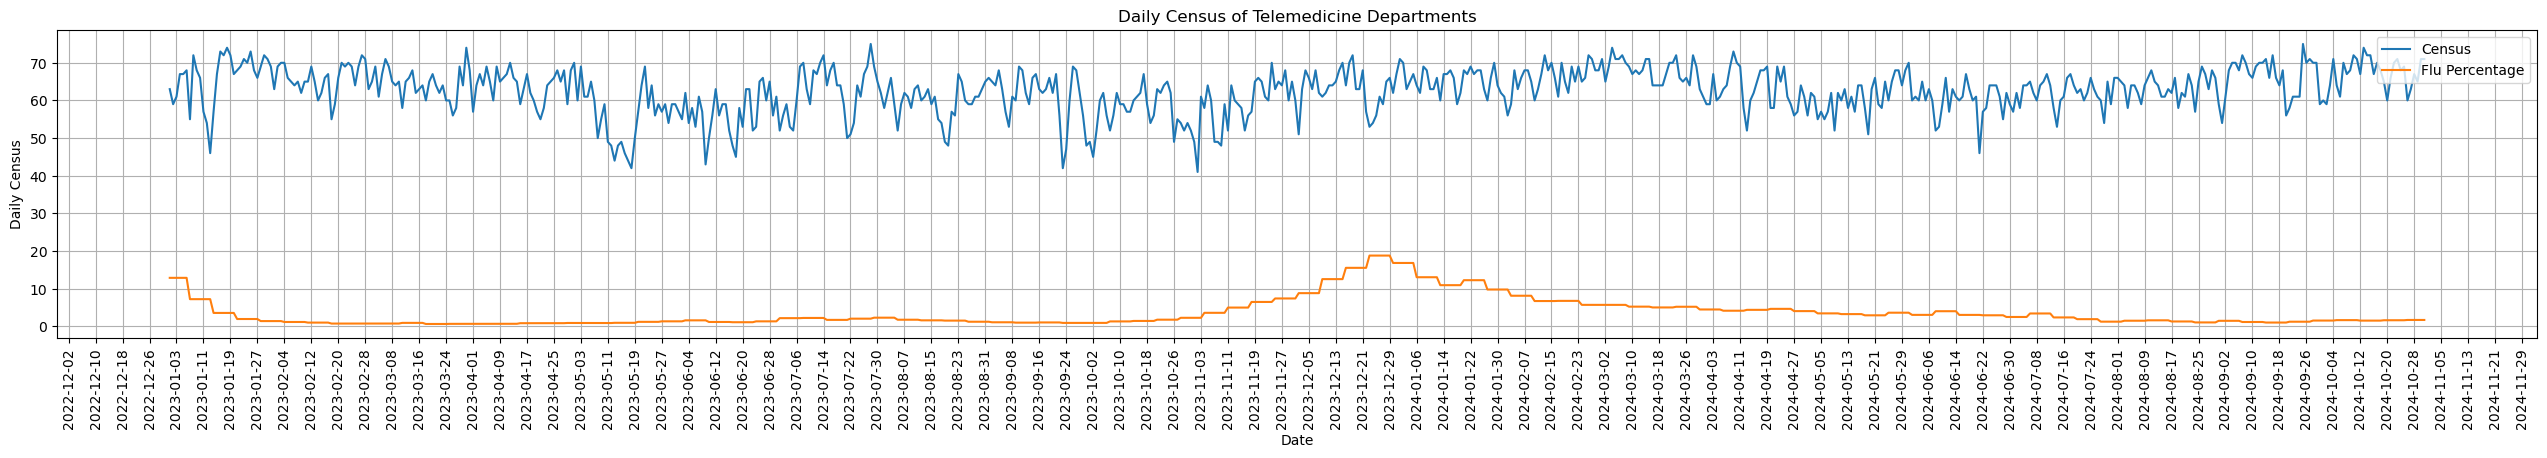

In [ ]:
# Plot the census data using SNS
plt.figure(figsize=(32,4))
sns.lineplot(x= agg_tele_census_df.index, y=agg_tele_census_df['Census'], data=agg_tele_census_df, label='Census')
sns.lineplot(x=agg_tele_census_df.index, y=agg_tele_census_df['perFlu'], data=agg_tele_census_df, label='Flu Percentage')
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(92))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Daily Census')
plt.title('Daily Census of Telemedicine Departments')
plt.legend(loc='upper right')
plt.show()

Text(0, 0.5, 'Daily Census')

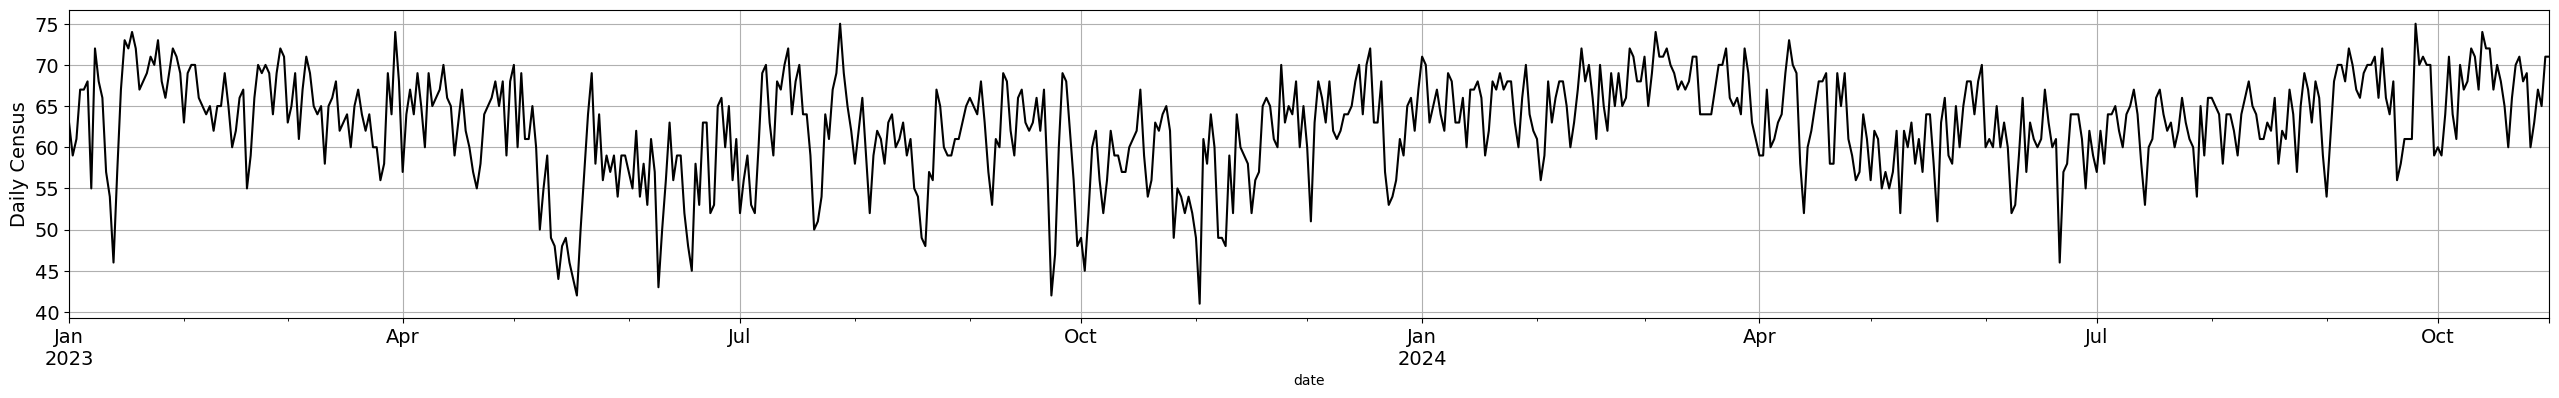

In [153]:
agg_tele_census_df['Census'].plot(figsize=(32,4),color='k',grid=True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Daily Census',fontsize=14)

In [128]:
# Preprocess the data
X = agg_tele_census_df[['Weekday', 'Month', 'perFlu']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [129]:
# Add the scaled features back to the DataFrame
agg_tele_census_df['Weekday_scaled'] = X_scaled[:, 0]
agg_tele_census_df['Month_scaled'] = X_scaled[:, 1]
agg_tele_census_df['perFlu_scaled'] = X_scaled[:, 2]
agg_tele_census_df.head()

,Census,Weekday,Month,perFlu,Weekday_scaled,Month_scaled,perFlu_scaled
date,,,,,,,
2023-01-01,63,6,1,12.871542,1.501402,-1.564178,2.444871
2023-01-02,59,0,1,12.871542,-1.496927,-1.564178,2.444871
2023-01-03,61,1,1,12.871542,-0.997206,-1.564178,2.444871
2023-01-04,67,2,1,12.871542,-0.497484,-1.564178,2.444871
2023-01-05,67,3,1,12.871542,0.002238,-1.564178,2.444871


In [130]:
# Split the data
y_hist, y_future = train_test_split(agg_tele_census_df, shuffle = False)

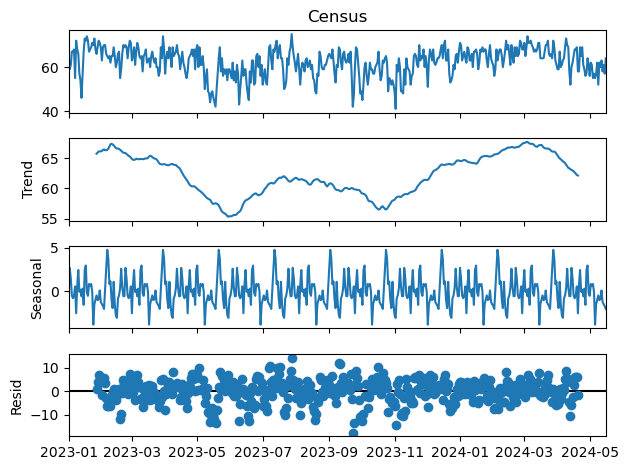

In [157]:
# Visualize the seasonal decomposition
seasonal_decompose_result =seasonal_decompose(y_hist['Census'], period=52)
seasonal_decompose_result.plot()
plt.show()

In [ ]:
# Check for stationarity
result = ts.adfuller(y_hist['Census'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("The series is stationary")
else:
    print("The series is non-stationary") 

ADF Statistic: -3.337391100587669
p-value: 0.01328761068533436
Critical Values: {'1%': -3.443849184997939, '5%': -2.8674931065091105, '10%': -2.569940776113236}
The series is stationary


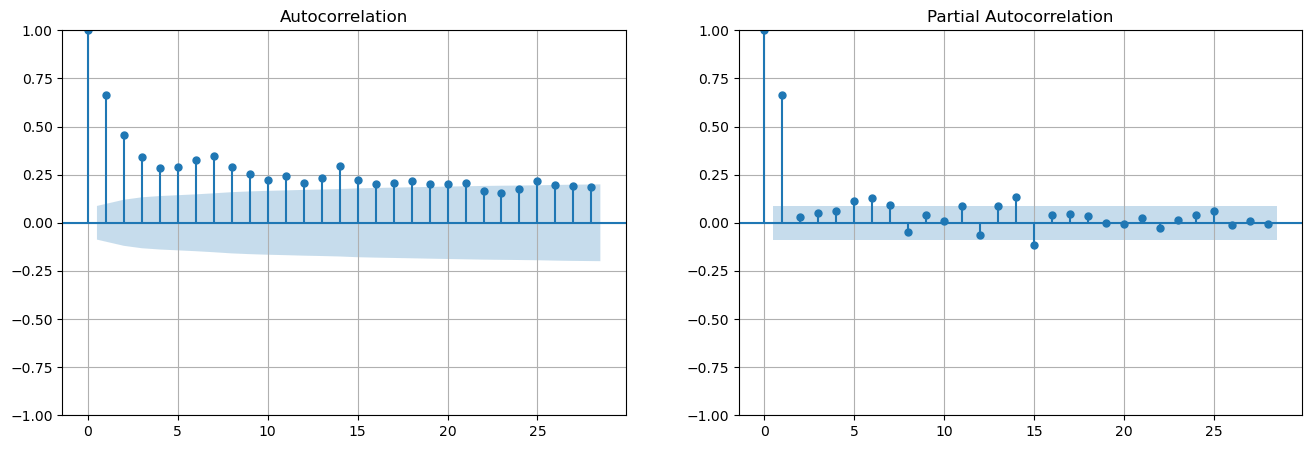

In [ ]:
# Check for autocorrelation and partial autocorrelation
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
plot_acf(y_hist['Census'], ax = ax[0]);
ax[0].grid()
plot_pacf(y_hist['Census'], ax = ax[1], method = 'ywm');
ax[1].grid()
plt.show()

In [134]:
# from the plot it looks like the data is stationary an acf p = 3 and pacf q = 1
# let's try to fit an ARIMA model

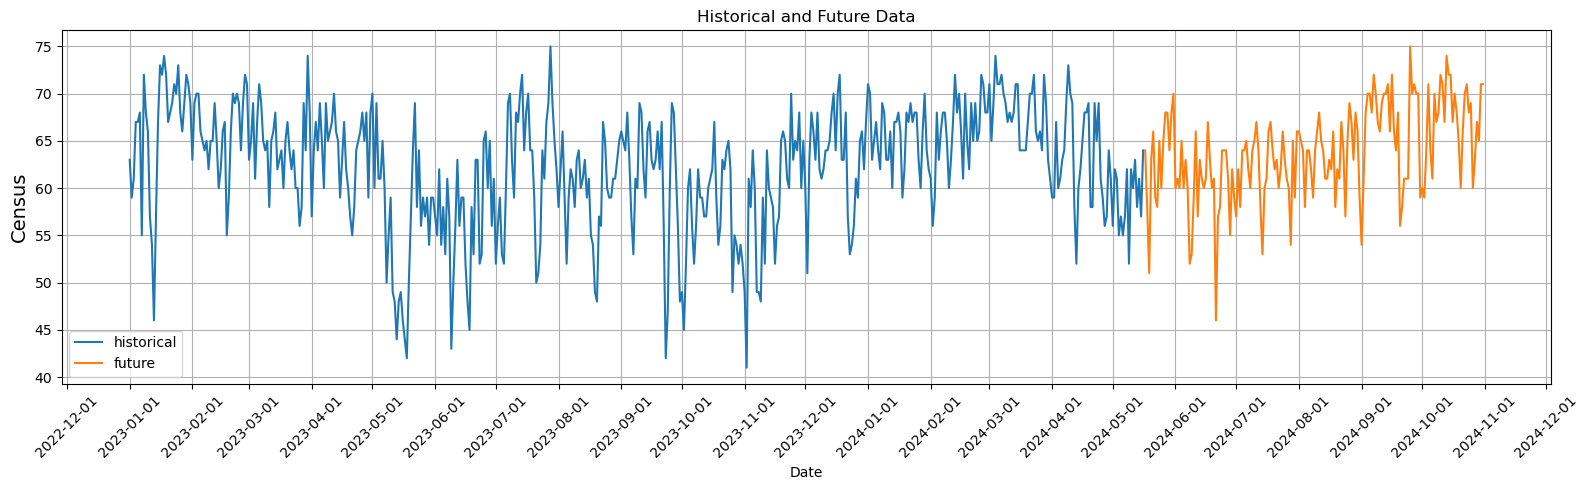

In [ ]:
# Plot the historical and future data
plt.figure(figsize=(16,5))
plt.plot(y_hist['Census'], label = 'historical')
plt.plot(y_future['Census'],  label = 'future')
plt.legend()

plt.grid()
# Use MonthLocator to set monthly ticks
from matplotlib.dates import MonthLocator, DateFormatter

# Create a locator object to generate monthly ticks
locator = MonthLocator(interval=1)  # Set interval to 1 for monthly ticks

# Create a formatter object to format the tick labels as YYYY-MM
formatter = DateFormatter('%Y-%m-%d')

# Set the locator and formatter for the x-axis
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

plt.ylabel('Census', fontsize=14)
plt.title('Historical and Future Data')
plt.xlabel('Date')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

In [136]:
import warnings
warnings.filterwarnings("ignore")

In [137]:
# ARIMA Model with scaling
arima_model = ARIMA(y_hist['Census'], order=(3, 0, 1), exog=y_hist[['Weekday_scaled', 'Month_scaled', 'perFlu_scaled']])  # Adjust p, d, q as needed
arima_model_fit = arima_model.fit()
arima_forecast = arima_model_fit.forecast(len(y_future), exog=y_future[['Weekday_scaled', 'Month_scaled', 'perFlu_scaled']])
print(arima_forecast)

2024-05-17    62.779606
2024-05-18    62.092387
2024-05-19    61.591926
2024-05-20    63.482668
2024-05-21    63.080152
                ...    
2024-10-27    57.836524
2024-10-28    59.838318
2024-10-29    59.504685
2024-10-30    59.171053
2024-10-31    58.837421
Freq: D, Name: predicted_mean, Length: 168, dtype: float64


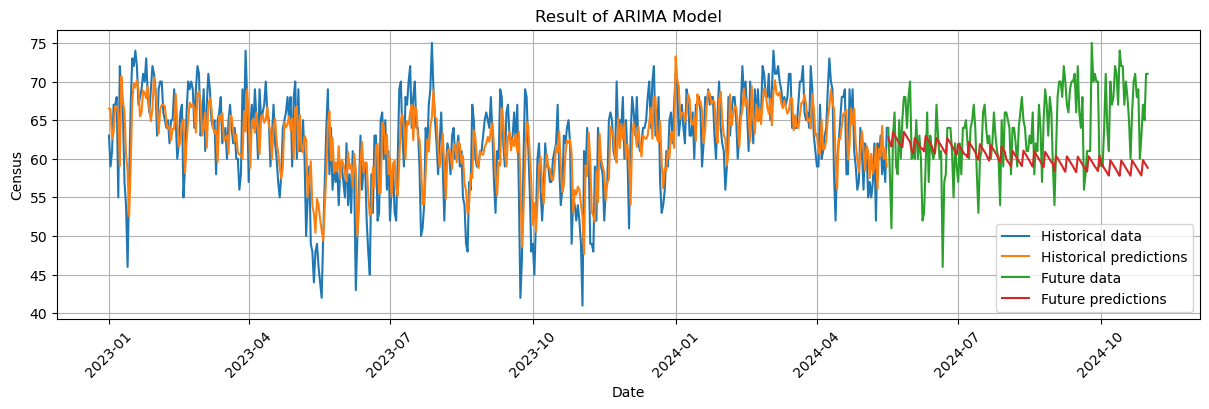

In [138]:
hist_preds = arima_model_fit.predict(len = len(y_hist), exog=y_hist[['Weekday_scaled', 'Month_scaled', 'perFlu_scaled']])
future_preds = arima_forecast


# Answer check
plt.figure(figsize = (12, 4))
plt.plot(y_hist['Census'], label = 'Historical data')
plt.plot(hist_preds, label = 'Historical predictions')
plt.plot(y_future['Census'], label = 'Future data')
plt.plot(future_preds, label = 'Future predictions')
plt.legend()
plt.grid()
plt.title('Result of ARIMA Model')
plt.xticks(rotation=45)  # Optional: Rotate for better readability
plt.tight_layout()  # Adjust spacing to avoid clipping labels
plt.xlabel('Date')
plt.ylabel('Census')
plt.show()


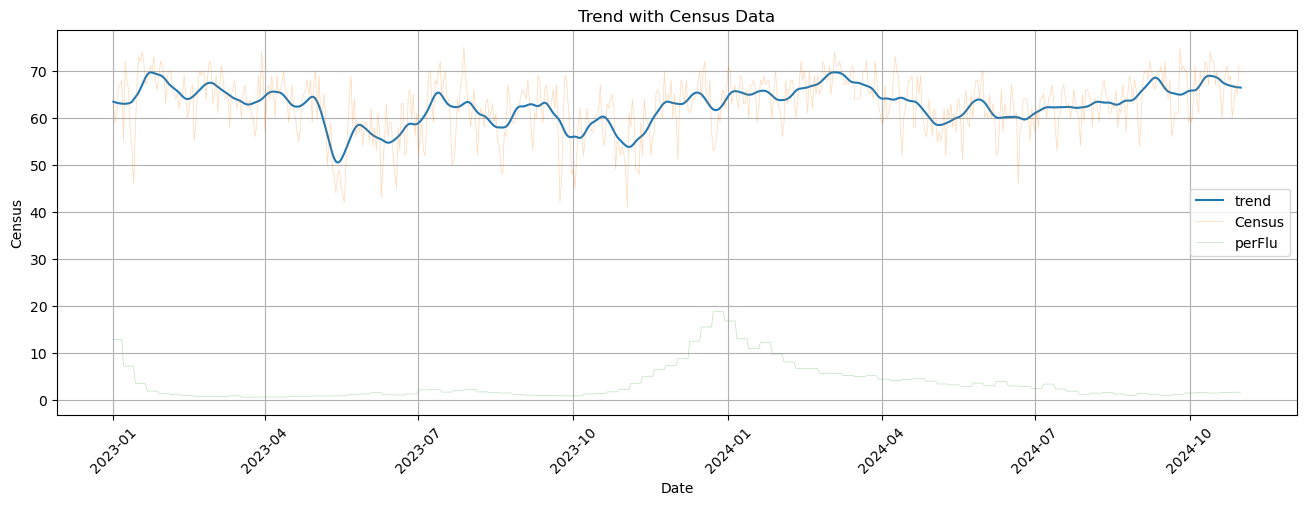

In [139]:
#Trend vs Census

stl = ''
results = ''

# YOUR CODE HERE
stl = STL(agg_tele_census_df['Census'].squeeze(), period=12, seasonal=7)
results = stl.fit()

## Answer check
plt.figure(figsize=(16,5))
plt.plot(results.trend, label = 'trend')
plt.plot(agg_tele_census_df[['Census', 'perFlu']].squeeze(), label = ['Census', 'perFlu'], alpha=0.3, linewidth=0.5)
plt.title('Trend with Census Data')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Census')
plt.grid()
plt.show()

In [140]:
#STL Forecasting with scaled Features

stlf = STLForecast(y_hist['Census'], ARIMA, model_kwargs={'order':(3, 0, 1), 'trend':"c", 'exog':y_hist[['Weekday_scaled', 'Month_scaled', 'perFlu_scaled']]}, period=12, seasonal=9)
#fit model using historical data
stlf_model = stlf.fit()
#produce forecast for future data
stlf_forecast = stlf_model.forecast(len(y_future), exog = y_future[['Weekday_scaled', 'Month_scaled', 'perFlu_scaled']])

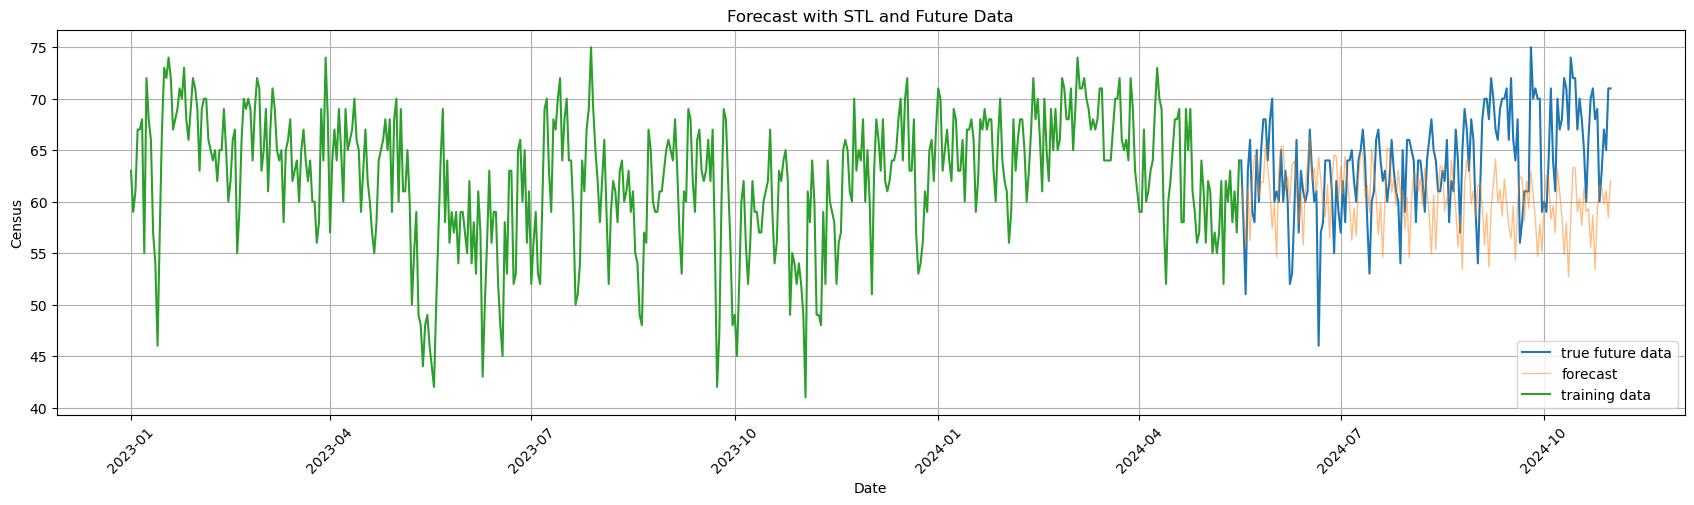

In [ ]:
# Plot the historical (training) and true future data to compare it against the forecast
plt.figure(figsize=(21,5))
plt.plot(y_future['Census'], label = 'true future data')
plt.plot(stlf_forecast, label = 'forecast',alpha=0.5, linewidth=1)
plt.plot(y_hist['Census'], label = 'training data')
plt.legend()    
plt.title('Forecast with STL and Future Data')
plt.grid()
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Census')
plt.show()

In [142]:
#Combine historical and future data
comparison_df_feature_scaled = pd.concat([y_hist, y_future], axis=0)
comparison_df_feature_scaled['Forecast'] = pd.concat([stlf_forecast], axis=0)
print(comparison_df_feature_scaled)

            Census  Weekday  Month     perFlu  Weekday_scaled  Month_scaled  \
date                                                                          
2023-01-01      63        6      1  12.871542        1.501402     -1.564178   
2023-01-02      59        0      1  12.871542       -1.496927     -1.564178   
2023-01-03      61        1      1  12.871542       -0.997206     -1.564178   
2023-01-04      67        2      1  12.871542       -0.497484     -1.564178   
2023-01-05      67        3      1  12.871542        0.002238     -1.564178   
...            ...      ...    ...        ...             ...           ...   
2024-10-27      63        6     10   1.682481        1.501402      1.214841   
2024-10-28      67        0     10   1.682481       -1.496927      1.214841   
2024-10-29      65        1     10   1.682481       -0.997206      1.214841   
2024-10-30      71        2     10   1.682481       -0.497484      1.214841   
2024-10-31      71        3     10   1.682481       

In [143]:
#RMSE & MAE
comparison_df1_cleaned = comparison_df_feature_scaled.dropna()
rmse = np.sqrt(mean_squared_error(comparison_df1_cleaned['Census'], comparison_df1_cleaned['Forecast']))
mae = mean_absolute_error(comparison_df1_cleaned['Census'].dropna(), comparison_df1_cleaned['Forecast'])

print('RMSE:', rmse)
print('MAE:', mae)

RMSE: 7.114714054776764
MAE: 5.682573954117352


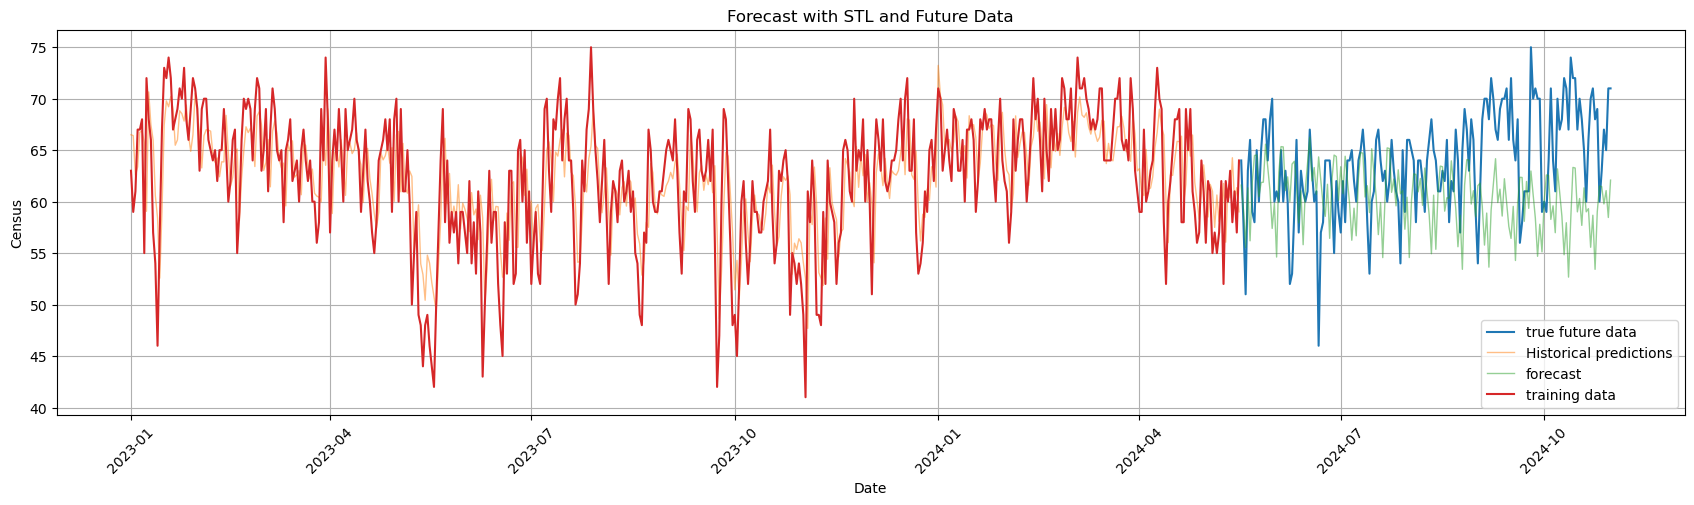

            Census  Weekday  Month     perFlu  Weekday_scaled  Month_scaled  \
date                                                                          
2023-01-01      63        6      1  12.871542        1.501402     -1.564178   
2023-01-02      59        0      1  12.871542       -1.496927     -1.564178   
2023-01-03      61        1      1  12.871542       -0.997206     -1.564178   
2023-01-04      67        2      1  12.871542       -0.497484     -1.564178   
2023-01-05      67        3      1  12.871542        0.002238     -1.564178   
...            ...      ...    ...        ...             ...           ...   
2024-10-27      63        6     10   1.682481        1.501402      1.214841   
2024-10-28      67        0     10   1.682481       -1.496927      1.214841   
2024-10-29      65        1     10   1.682481       -0.997206      1.214841   
2024-10-30      71        2     10   1.682481       -0.497484      1.214841   
2024-10-31      71        3     10   1.682481       

In [ ]:
# ARIMA Model without scaled features
arima_model = ARIMA(y_hist['Census'], order=(3, 0, 1), exog=y_hist[['Weekday', 'Month', 'perFlu']])  # Adjust p, d, q as needed
arima_model_fit = arima_model.fit()
arima_forecast = arima_model_fit.forecast(len(y_future), exog=y_future[['Weekday', 'Month', 'perFlu']])
#print(arima_forecast)

hist_preds = arima_model_fit.predict(len = len(y_hist), exog=y_hist[['Weekday', 'Month', 'perFlu']])
future_preds = arima_forecast

stlf = STLForecast(y_hist['Census'], ARIMA, model_kwargs={'order':(3, 0, 1), 'trend':"c", 'exog':y_hist[['Weekday', 'Month', 'perFlu']]}, period=12, seasonal=9)
stlf_model = stlf.fit()
stlf_forecast = stlf_model.forecast(len(y_future), exog = y_future[['Weekday', 'Month', 'perFlu']])

# Plot the historical (training) and true future data to compare it against the forecast
plt.figure(figsize=(21,5))
plt.plot(y_future['Census'], label = 'true future data')
plt.plot(hist_preds, label = 'Historical predictions',alpha=0.5, linewidth=1)
plt.plot(stlf_forecast, label = 'forecast',alpha=0.5, linewidth=1)
plt.plot(y_hist['Census'], label = 'training data')
plt.legend()    
plt.title('Forecast with STL and Future Data')
plt.grid()
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Census')
plt.show()

comparison_df_wo_scaling = pd.concat([y_hist, y_future], axis=0)
comparison_df_wo_scaling['Forecast'] = pd.concat([stlf_forecast], axis=0)
print(comparison_df_wo_scaling)

#RMSE & MAE
comparison_df2_cleaned = comparison_df_wo_scaling.dropna()
rmse_woscaling = np.sqrt(mean_squared_error(comparison_df2_cleaned['Census'], comparison_df2_cleaned['Forecast']))
mae_woscaling = mean_absolute_error(comparison_df2_cleaned['Census'].dropna(), comparison_df2_cleaned['Forecast'])

print('RMSE:', rmse_woscaling)
print('MAE:', mae_woscaling)

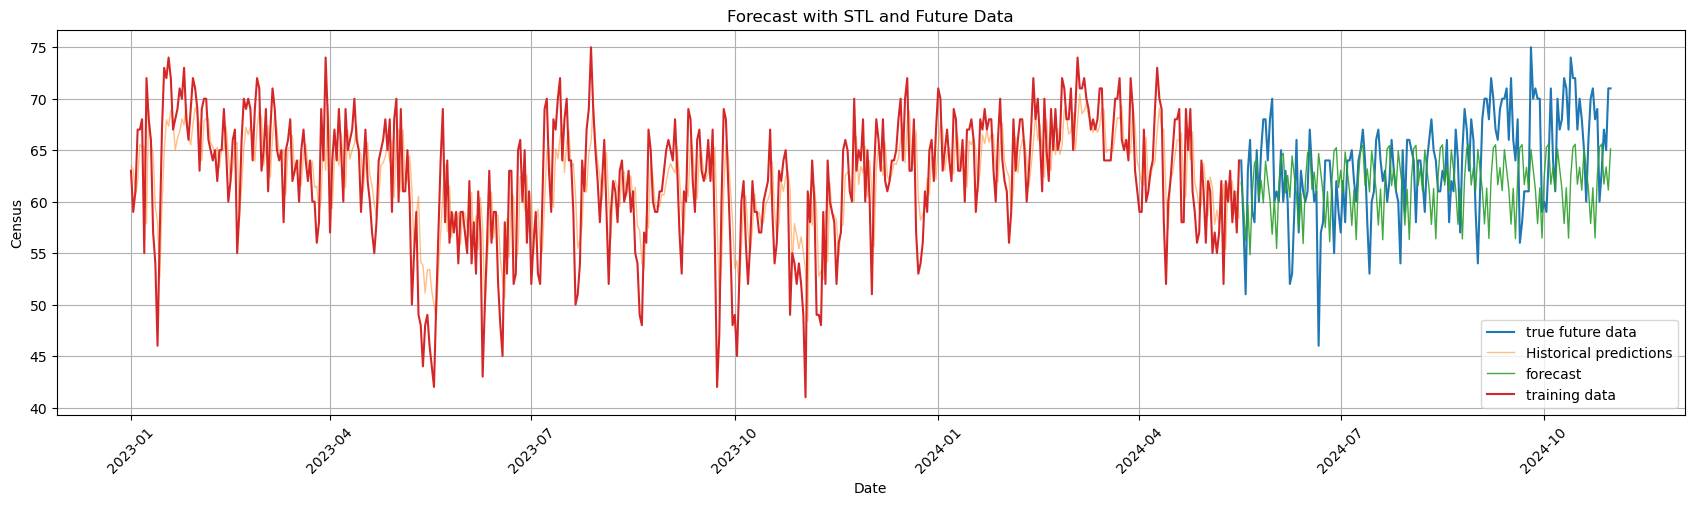

            Census  Weekday  Month     perFlu  Weekday_scaled  Month_scaled  \
date                                                                          
2023-01-01      63        6      1  12.871542        1.501402     -1.564178   
2023-01-02      59        0      1  12.871542       -1.496927     -1.564178   
2023-01-03      61        1      1  12.871542       -0.997206     -1.564178   
2023-01-04      67        2      1  12.871542       -0.497484     -1.564178   
2023-01-05      67        3      1  12.871542        0.002238     -1.564178   
...            ...      ...    ...        ...             ...           ...   
2024-10-27      63        6     10   1.682481        1.501402      1.214841   
2024-10-28      67        0     10   1.682481       -1.496927      1.214841   
2024-10-29      65        1     10   1.682481       -0.997206      1.214841   
2024-10-30      71        2     10   1.682481       -0.497484      1.214841   
2024-10-31      71        3     10   1.682481       

In [ ]:
# ARIMA Model with just flu data
arima_model = ARIMA(y_hist['Census'], order=(3, 0, 1), exog=y_hist[['perFlu']])  # Adjust p, d, q as needed
arima_model_fit = arima_model.fit()
arima_forecast = arima_model_fit.forecast(len(y_future), exog=y_future[['perFlu']])
#print(arima_forecast)

hist_preds = arima_model_fit.predict(len = len(y_hist), exog=y_hist[['perFlu']])
future_preds = arima_forecast



stlf = STLForecast(y_hist['Census'], ARIMA, model_kwargs={'order':(3, 0, 1), 'trend':"c", 'exog':y_hist[['perFlu']]}, period=12, seasonal=9)
stlf_model = stlf.fit()
stlf_forecast = stlf_model.forecast(len(y_future), exog = y_future[['perFlu']])

# Plot the historical (training) and true future data to compare it against the forecast
plt.figure(figsize=(21,5))
plt.plot(y_future['Census'], label = 'true future data')
plt.plot(hist_preds, label = 'Historical predictions',alpha=0.5, linewidth=1)
plt.plot(stlf_forecast, label = 'forecast',alpha=0.9, linewidth=1)
plt.plot(y_hist['Census'], label = 'training data')
plt.legend()    
plt.title('Forecast with STL and Future Data')
plt.grid()
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Census')
plt.show()

comparison_df_flu = pd.concat([y_hist, y_future], axis=0)
comparison_df_flu['Forecast'] = pd.concat([stlf_forecast], axis=0)
print(comparison_df_flu)

#RMSE & MAE
comparison_df3_cleaned = comparison_df_flu.dropna()
rmse_wflu = np.sqrt(mean_squared_error(comparison_df3_cleaned['Census'], comparison_df3_cleaned['Forecast']))
mae_wflu = mean_absolute_error(comparison_df3_cleaned['Census'].dropna(), comparison_df3_cleaned['Forecast'])
print('RMSE:', rmse_wflu)
print('MAE:', mae_wflu)

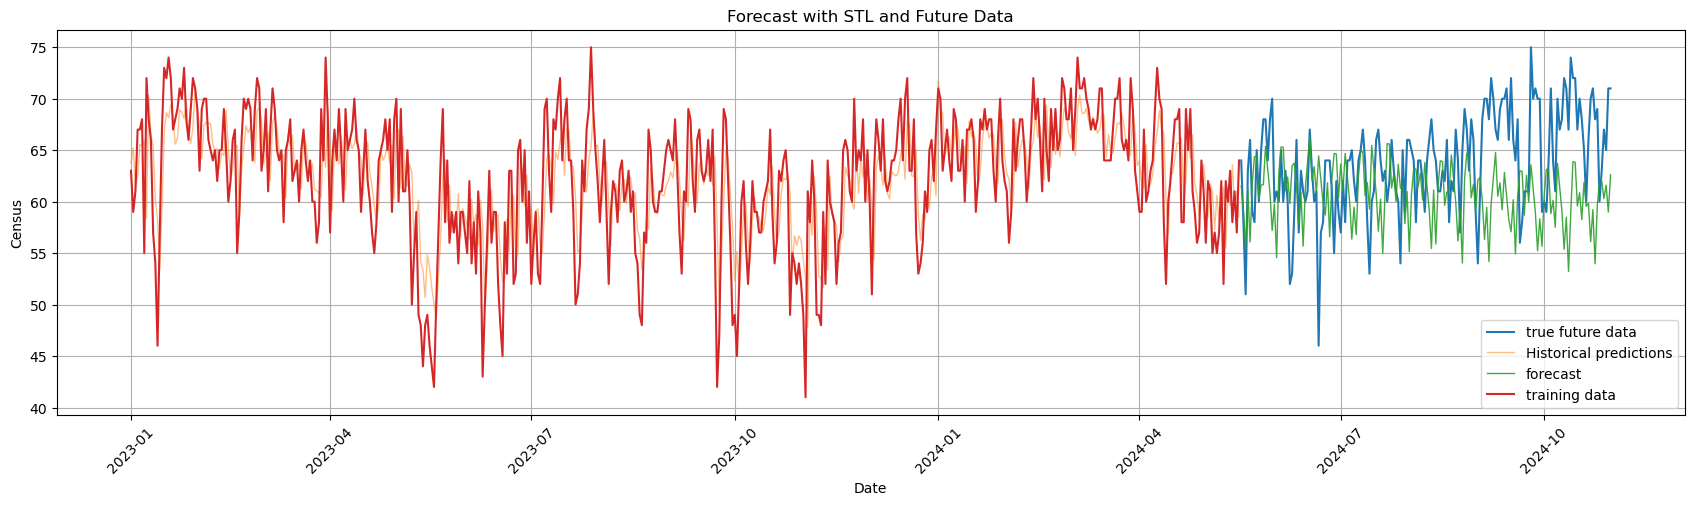

            Census  Weekday  Month     perFlu  Weekday_scaled  Month_scaled  \
date                                                                          
2023-01-01      63        6      1  12.871542        1.501402     -1.564178   
2023-01-02      59        0      1  12.871542       -1.496927     -1.564178   
2023-01-03      61        1      1  12.871542       -0.997206     -1.564178   
2023-01-04      67        2      1  12.871542       -0.497484     -1.564178   
2023-01-05      67        3      1  12.871542        0.002238     -1.564178   
...            ...      ...    ...        ...             ...           ...   
2024-10-27      63        6     10   1.682481        1.501402      1.214841   
2024-10-28      67        0     10   1.682481       -1.496927      1.214841   
2024-10-29      65        1     10   1.682481       -0.997206      1.214841   
2024-10-30      71        2     10   1.682481       -0.497484      1.214841   
2024-10-31      71        3     10   1.682481       

In [ ]:
# ARIMA Model with just Weekday and Month
arima_model = ARIMA(y_hist['Census'], order=(3, 0, 1), exog=y_hist[['Weekday', 'Month']])  # Adjust p, d, q as needed
arima_model_fit = arima_model.fit()
arima_forecast = arima_model_fit.forecast(len(y_future), exog=y_future[['Weekday', 'Month']])
#print(arima_forecast)

hist_preds = arima_model_fit.predict(len = len(y_hist), exog=y_hist[['Weekday', 'Month']])
future_preds = arima_forecast



stlf = STLForecast(y_hist['Census'], ARIMA, model_kwargs={'order':(3, 0, 1), 'trend':"c", 'exog':y_hist[['Weekday', 'Month']]}, period=12, seasonal=9)
stlf_model = stlf.fit()
stlf_forecast = stlf_model.forecast(len(y_future), exog = y_future[['Weekday', 'Month']])

# Plot the historical (training) and true future data to compare it against the forecast
plt.figure(figsize=(21,5))
plt.plot(y_future['Census'], label = 'true future data')
plt.plot(hist_preds, label = 'Historical predictions',alpha=0.5, linewidth=1)
plt.plot(stlf_forecast, label = 'forecast',alpha=0.9, linewidth=1)
plt.plot(y_hist['Census'], label = 'training data')
plt.legend()    
plt.title('Forecast with STL and Future Data')
plt.grid()
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Census')
plt.show()

comparison_df_wo_flu = pd.concat([y_hist, y_future], axis=0)
comparison_df_wo_flu['Forecast'] = pd.concat([stlf_forecast], axis=0)
print(comparison_df_flu)

#RMSE & MAE
comparison_df4_cleaned = comparison_df_wo_flu.dropna()
rmse_woflu = np.sqrt(mean_squared_error(comparison_df4_cleaned['Census'], comparison_df4_cleaned['Forecast']))
mae_woflu= mean_absolute_error(comparison_df4_cleaned['Census'].dropna(), comparison_df4_cleaned['Forecast'])
print('RMSE:', rmse_woflu)
print('MAE:', mae_woflu)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2980.969, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3081.269, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3063.886, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3049.047, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3079.269, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2980.842, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2996.754, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2979.962, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2980.675, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3049.440, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2978.050, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3047.047, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3061.886, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2978.757, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]          

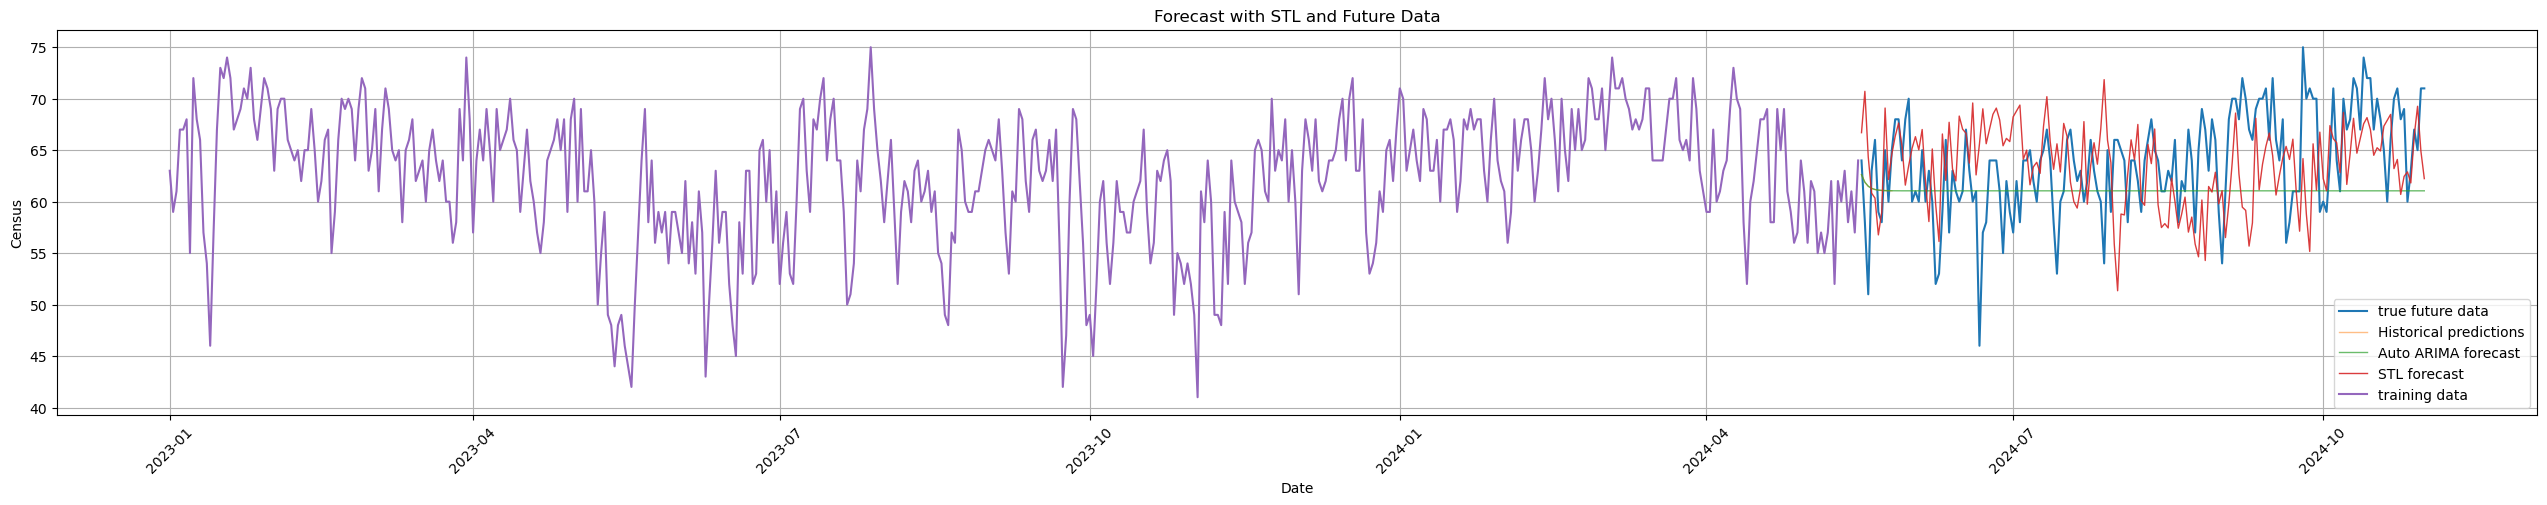

            Census  AA_Forecast  STL_Forecast
date                                         
2024-05-17      64    62.619528     66.698749
2024-05-18      58    61.885205     70.714263
2024-05-19      51    61.494592     64.333745
2024-05-20      63    61.286811     60.823886
2024-05-21      66    61.176285     60.343497
...            ...          ...           ...
2024-10-27      63    61.050677     61.817499
2024-10-28      67    61.050677     66.354920
2024-10-29      65    61.050677     69.262289
2024-10-30      71    61.050677     64.881233
2024-10-31      71    61.050677     62.237002

[168 rows x 3 columns]
RMSE: 6.2866731849374915
MAE: 5.033815236154509


In [ ]:
# Auto ARIMA Model with just perFlu
# Automatically find the best ARIMA model
auto_arima_model = auto_arima(y_hist['Census'], exogenous=y_hist[['perFlu']], seasonal=True, stepwise=True, trace=True)
print(auto_arima_model.summary())

# Fit the best model found
arima_model_fit = auto_arima_model.fit(y_hist['Census'], exogenous=y_hist[['perFlu']])

# Forecast future values
hist_preds = arima_model_fit.predict(len = len(y_hist), exog=y_hist[['perFlu']])
auto_arima_forecast = arima_model_fit.predict(n_periods=len(y_future), exogenous=y_future[['perFlu']])
future_preds = auto_arima_forecast
rmse_auto_arima = np.sqrt(np.mean((future_preds - y_future['Census'])**2))
mae_auto_arima = mean_absolute_error(future_preds, y_future['Census'])
print('RMSE_Auto_ARIMA:', rmse_auto_arima)
print('MAE_Auto_ARIMA:', mae_auto_arima)



stlf = STLForecast(y_hist['Census'], SARIMAX, model_kwargs={'order':(1,1,1), 'seasonal_order':(0,0,0,0), 'trend':"c", 'exog':y_hist[['perFlu']]}, period=110, seasonal=5)
stlf_model = stlf.fit()
stlf_forecast = stlf_model.forecast(len(y_future), exog = y_future[['perFlu']])

# Plot the historical (training) and true future data to compare it against the forecast
plt.figure(figsize=(32,5))
plt.plot(y_future['Census'], label = 'true future data')
plt.plot(hist_preds, label = 'Historical predictions',alpha=0.5, linewidth=1)
plt.plot(auto_arima_forecast, label = 'Auto ARIMA forecast',alpha=0.7, linewidth=1)
plt.plot(stlf_forecast, label = 'STL forecast',alpha=0.9, linewidth=1)
plt.plot(y_hist['Census'], label = 'training data')
plt.legend()    
plt.title('Forecast with STL and Future Data')
plt.grid()

plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Census')
plt.show()


comparison_auto_arima_df_flu = pd.concat([y_hist, y_future], axis=0)
comparison_auto_arima_df_flu['AA_Forecast'] = pd.concat([auto_arima_forecast], axis=0)
comparison_auto_arima_df_flu['STL_Forecast'] = pd.concat([stlf_forecast], axis=0)
print(comparison_auto_arima_df_flu[['Census', 'AA_Forecast', 'STL_Forecast']][comparison_auto_arima_df_flu['STL_Forecast'].notnull()])
#print("Forecasted values:", auto_arima_forecast)

# Evaluate the model
comparison_df5_cleaned = comparison_auto_arima_df_flu.dropna()
rmse_wflu = np.sqrt(mean_squared_error(comparison_df5_cleaned['Census'], comparison_df5_cleaned['STL_Forecast']))
mae_wflu = mean_absolute_error(comparison_df5_cleaned['Census'], comparison_df5_cleaned['STL_Forecast'])
print('RMSE:', rmse_wflu)
print('MAE:', mae_wflu)

In [148]:
comparison_df5_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 2024-05-17 to 2024-10-31
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Census          168 non-null    int64  
 1   Weekday         168 non-null    int32  
 2   Month           168 non-null    int32  
 3   perFlu          168 non-null    float64
 4   Weekday_scaled  168 non-null    float64
 5   Month_scaled    168 non-null    float64
 6   perFlu_scaled   168 non-null    float64
 7   AA_Forecast     168 non-null    float64
 8   STL_Forecast    168 non-null    float64
dtypes: float64(6), int32(2), int64(1)
memory usage: 11.8 KB


In [ ]:
# Create a DataFrame to store the predicted values and actual values for comparison and analysis
predicted_staffing_df = pd.DataFrame({ 'Actual Census': y_future['Census'], 'Model - Auto ARIMA': auto_arima_forecast.round().astype(int), 'Model - STL [Sarimax]': stlf_forecast.round().astype(int)})

In [150]:
predicted_staffing_df

,Actual Census,Model - Auto ARIMA,Model - STL [Sarimax]
2024-05-17,64,63,67
2024-05-18,58,62,71
2024-05-19,51,61,64
2024-05-20,63,61,61
2024-05-21,66,61,60
...,...,...,...
2024-10-27,63,61,62
2024-10-28,67,61,66
2024-10-29,65,61,69
2024-10-30,71,61,65


In [ ]:
# Convert predicted values to staffing levels based on the model's output taking into account staffing ratio is 1:5 unless census is less than 5
predicted_staffing_df['Staffing_Model_1'] = predicted_staffing_df.apply(lambda row: (row['Model - Auto ARIMA']/5).round().astype(int) if row['Model - Auto ARIMA'] > 5 else 2, axis=1)
predicted_staffing_df['Staffing_Model_2'] = predicted_staffing_df.apply(lambda row: (row['Model - STL [Sarimax]']/5).round().astype(int) if row['Model - STL [Sarimax]'] > 5 else 2, axis=1)
predicted_staffing_df

,Actual Census,Model - Auto ARIMA,Model - STL [Sarimax],Staffing_Model_1,Staffing_Model_2
2024-05-17,64,63,67,13,13
2024-05-18,58,62,71,12,14
2024-05-19,51,61,64,12,13
2024-05-20,63,61,61,12,12
2024-05-21,66,61,60,12,12
...,...,...,...,...,...
2024-10-27,63,61,62,12,12
2024-10-28,67,61,66,12,13
2024-10-29,65,61,69,12,14
2024-10-30,71,61,65,12,13


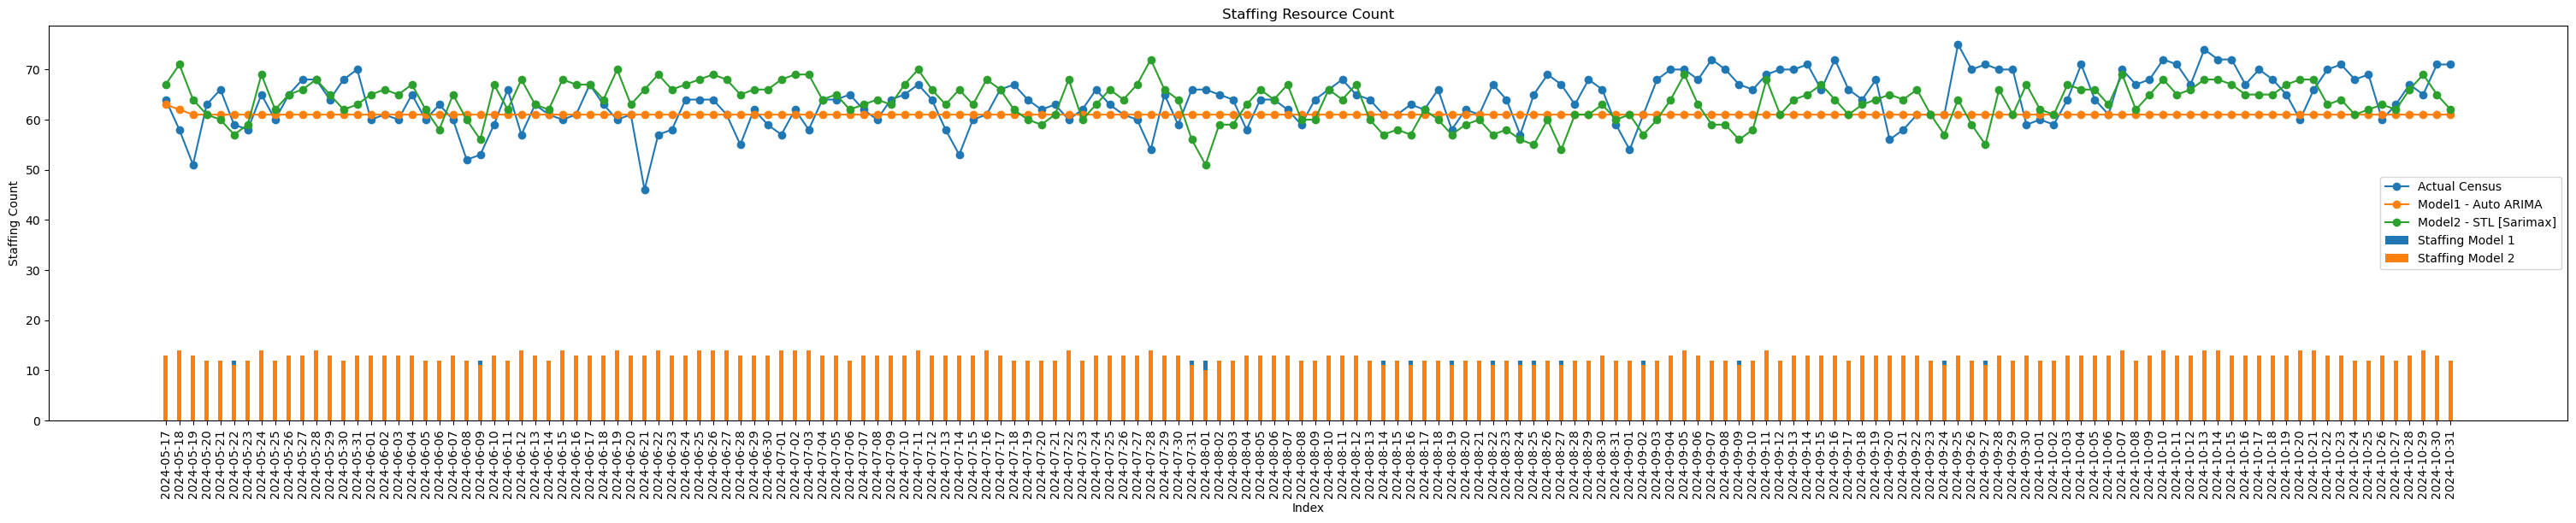

In [152]:
# Plotting
plt.figure(figsize=(38, 6))

# Line plot for census data

plt.plot(predicted_staffing_df.index, predicted_staffing_df['Actual Census'], label='Actual Census', marker='o')
plt.plot(predicted_staffing_df.index, predicted_staffing_df['Model - Auto ARIMA'], label='Model1 - Auto ARIMA', marker='o')
plt.plot(predicted_staffing_df.index, predicted_staffing_df['Model - STL [Sarimax]'], label='Model2 - STL [Sarimax]', marker='o')
plt.title('Census Data Comparison')
plt.xlabel('Index')
plt.ylabel('Census Count')
plt.legend()

# Bar plot for staffing resources

bar_width = 0.35
index = predicted_staffing_df.index
plt.bar(index, predicted_staffing_df['Staffing_Model_1'], bar_width, label='Staffing Model 1')
plt.bar(index, predicted_staffing_df['Staffing_Model_2'], bar_width, label='Staffing Model 2')
plt.title('Staffing Resource Count')
plt.xlabel('Index')
plt.ylabel('Staffing Count')
plt.xticks(index, predicted_staffing_df.index.strftime('%Y-%m-%d'), rotation=90)
plt.legend()

plt.show()

In [ ]:
#Future testing - Linear Regression

In [166]:
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming you have a DataFrame 'df' with columns 'Census', 'perFlu', 'weekday', and 'month'

# Prepare the data
X = agg_tele_census_df[['Census', 'perFlu', 'Weekday', 'Month']]
y = agg_tele_census_df['Census']

# Create a preprocessing pipeline
preprocessor = Pipeline([
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', drop='first')),
    ('scaler', MaxAbsScaler())
])

# Fit the preprocessor to the data and transform it
X_transformed = preprocessor.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42,shuffle=False)
# Create a linear regression model
model = LinearRegression()

# Perform grid search with cross-validation
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'fit_intercept': [True, False]
}
grid_search = GridSearchCV(model, param_grid, cv=tscv)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print('RMSE:', rmse)
print('MAE:', mae)

RMSE: 0.0003411729346270507
MAE: 0.00025749999339494357


In [168]:
print (y_pred)

[60.99958375 45.99954084 57.00081944 58.0008963  64.00079387 64.00081457
 64.00081786 61.00094589 55.00079849 62.00087874 59.00086889 56.9996806
 61.99976061 57.99983403 63.99967167 63.99971808 64.99978245 61.99968752
 59.99977288 63.99967593 64.99980624 66.9998003  63.99971808 57.99981024
 52.99979684 59.99977288 60.99981151 65.99979728 66.9998003  63.99971808
 61.9997401  62.99971937 59.99977288 61.99976061 65.99979728 62.99978818
 60.99985366 59.99977308 53.99996307 64.99978226 58.99980333 65.99979728
 66.00047681 65.00053219 64.00034251 58.00044475 64.00034231 64.00036302
 62.00045098 59.00048615 64.00040516 66.00046057 68.00042007 65.00046934
 64.00036302 61.00050188 61.00049433 63.00052168 62.00042718 66.00040799
 58.00049713 62.00044769 61.00050188 67.00048739 64.00040516 57.00036789
 65.00041696 69.00048986 67.00049166 63.00048282 68.00048889 66.00052322
 59.00046991 54.00021364 61.00004139 68.00005665 69.99993578 69.99992822
 68.00009879 72.00004942 69.99985941 67.00003445 66.